In [1]:
# Script for investigating amplitude dependence of potential

@everywhere using Distributions
@everywhere using Base.Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
using MCMCDiagnostics
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
using Primes
pyplot()

Plots.PyPlotBackend()

# Binning and autocorrelation times
First we need to implement code for splitting an array of floats into blocks and then checking that the number of elements in a block is sufficient to deminish autocorrelation effects.

In [3]:
mutable struct BlockInd
    N::Int64    # The number of elements in the time-series
    Nb::Int64   # The number of elements in a block
    n::Int64    # The number of blocks n = N/Nb
end

In [4]:
function BlockInd(N::Int64, Nb::Int64)
    Nb != 0 || throw(error("Can not have 0 block length"))
    if N < Nb || N%Nb != 0
        throw(error("Domain error. $(N) not divisible by $(Nb)"))
    end
    n = N/Nb
    return BlockInd(N, Nb, n)
end

BlockInd

In [5]:
function iterator(B::BlockInd, t::Int64)
    return (t-1)*B.Nb+1:t*B.Nb
end

iterator (generic function with 1 method)

In [6]:
import Base.getindex
function getindex(B::BlockInd, t::Int64)
    return [i for i = iterator(B,t)]#(t-1)*B.Nb+1:t*B.Nb]
end

getindex (generic function with 275 methods)

In [24]:
mean(rand(10))

0.5964377372503602

In [7]:
function mapToBlockedSeries{T<:Real}(O::Array{T, 1}, B::BlockInd)
    O_aux = Array{T}(B.n)
    for t = 1:B.n
        O_aux[t] = mean(O[iterator(B,t)])#(t-1)*B.Nb+1:t*B.Nb])
    end
    return O_aux
end

mapToBlockedSeries (generic function with 1 method)

In [15]:
# Slower version of the one above.
function mapToBlockedSeries2{T<:Real}(O::Array{T, 1}, B::BlockInd)
    O_aux = Array{T}(B.n)
    for t = 1:B.n
        O_sum = 0
        for i in B[t]
            O_sum += O[i]
        end
        O_aux[t] = O_sum/B.Nb
    end
    return O_aux
end

mapToBlockedSeries2 (generic function with 1 method)

In [16]:
# Warning: this is a slow version. Use built in var(O)/length(O) instead.

# Calculation of naive variance estimator
function naiveVar{T<:Real}(O::Array{T, 1}; mn=nothing)
    if mn == nothing
        mn = mean(O)
    end
    N = length(O)
    O_sum = sum(abs2, O-mn)
    return O_sum/(N*(N-1))
end

naiveVar (generic function with 1 method)

In [8]:
function varByBlockLength{T<:Real, I<:Int}(O::Array{T, 1}, Nb_list::Array{I, 1})
    N = length(O)
    M = length(Nb_list)
    var_list = Array{Float64}(M)
    var_error_list = Array{Float64}(M)
    
    for (i, Nb) in enumerate(Nb_list)
        B = BlockInd(N,Nb)
        O_aux = mapToBlockedSeries(O, B)
        var_list[i]  = var(O_aux)/B.n
        var_error_list[i] = var_list[i]*√(2/(B.n-1))
    end
    return var_list, var_error_list
end

varByBlockLength (generic function with 1 method)

In [9]:
# Checks if the element Y[i] is within the error of the points Y[j] for i<j such that 
# Y[i] ∈ [Y[j]-err[j], Y[j]+err[j]]
function isWithinErrorOfRightPoints{T<:Real}(i::Int64, Y::Array{T,1}, err::Array{T,1}; err_weight=1.0)
    for j = i+1:length(Y)
        if Y[i] < Y[j]-err_weight*err[j] || Y[i] > Y[j]+err_weight*err[j]
            return false
        end
    end
    return true
end

isWithinErrorOfRightPoints (generic function with 1 method)

In [10]:
function firstConvergedIndex{T<:Real}(Y::Array{T,1}, err::Array{T,1})
    for i = 1:length(Y)
        if isWithinErrorOfRightPoints(i, Y, err)
            return i
        end
    end
    return -1
end

firstConvergedIndex (generic function with 1 method)

In [11]:
# --------------------------------------------------------------------------------------------------
# Returns a sorted array of divisors of M except for 1 and M.
function divisors(M::Int; sorting=true)
    # First we calculate all the divisors of M except for 1 and M
    # and save them in the divisors array.
    pr = primes(2,Int(floor(sqrt(M)))+2)
    L = size(pr, 1)
    divisors = Array{Int}(0)
    m = M
    for i = 1:L
        while(m%pr[i]==0)
            m /= pr[i]
            if m == 1
                break
            end
            push!(divisors, m)
            push!(divisors, M/m)
        end
    end
    
    # Then we sort this array so that high divisors come first and
    # iterate through it until a match is found.
    if sorting
        return sort(unique(divisors), rev=true)
    else
        return unique(divisors)
    end
end



divisors (generic function with 1 method)

In [12]:
function smallestBlockSize{T<:Real}(O_series::Array{T,1}; write_plot=false, filename="block_size_variance_plt.png")
    N = length(O_series)
    # Find the possible block sizes of the series {O}
    Nb_list = reverse(divisors(N))
    
    # Calculate the variance its error when using the different possible block lengths
    var_list, error_list = varByBlockLength(O_series, Nb_list)
    i = firstConvergedIndex(var_list, error_list)
    if i == -1
        plt = scatter(Nb_list, var_list; xscale=:log2, yerror=error_list, yaxis="S²", xaxis="Nb",
            title="Variance when dividing the series using block length Nb")
        savefig(plt, filename)
        throw(error("ERROR: Could not determine minimum block size. Increase series length?"))
    end
    if write_plot
        plt = scatter(Nb_list, var_list; xscale=:log2, yerror=error_list, yaxis="S²", xaxis="Nb",
            title="Variance when dividing the series using block length Nb")
        savefig(plt, filename)
    end
    return Nb_list[i]
end

smallestBlockSize (generic function with 1 method)

In [49]:
BlockInd(2^12, 2^11)

BlockInd(4096, 2048, 2)

# Testing Binning

In [50]:
@benchmark var(energies)/length(energies)

BenchmarkTools.Trial: 
  memory estimate:  192 bytes
  allocs estimate:  7
  --------------
  minimum time:     1.660 μs (0.00% GC)
  median time:      1.702 μs (0.00% GC)
  mean time:        1.784 μs (0.00% GC)
  maximum time:     5.290 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [51]:
@benchmark naiveVar(energies)

BenchmarkTools.Trial: 
  memory estimate:  7.97 KiB
  allocs estimate:  3
  --------------
  minimum time:     3.067 μs (0.00% GC)
  median time:      4.663 μs (0.00% GC)
  mean time:        5.702 μs (18.59% GC)
  maximum time:     523.436 μs (95.08% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [2]:
# Create a realistic time-series of the energies in a Markov-chain.

g = 1.0    # Gauge coupling
ν = 0.3    # Anisotropy
L = 12
L₃ = 12
κ₅ = 1.0
f = 0.0/L
T = 3.5
sim = Controls(π-π/12, 1.0, 4.0)
syst = SystConstants(L, L₃, 1/g^2, ν, κ₅, f, 1/T) 
M = 2^12
Δt = 10

energies = Array{Float64}(M)
ψ = State(1, syst; u⁺=1.0, u⁻=0.0)
@time for m = 1:M
    for t = 1:Δt
        mcSweep!(ψ, sim)
    end
    energies[m] = E(ψ)
end

466.733083 seconds (849.42 M allocations: 30.588 GiB, 1.59% gc time)


In [13]:
Nb_list = [2^i for i = 1:11]
var_list, error_list = varByBlockLength(energies, Nb_list);

In [14]:
length(energies)

4096

In [21]:
2^5*10

320

true


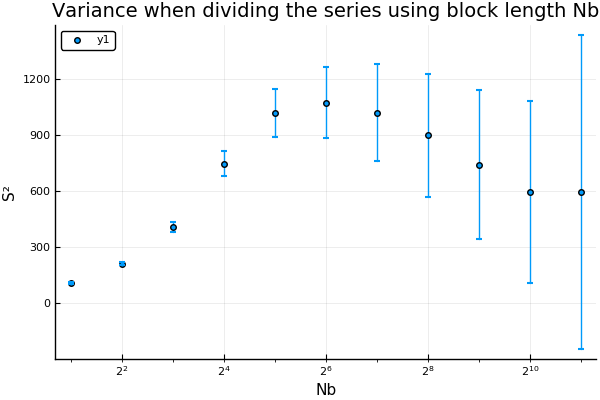

In [15]:
using Plots
println(length(Nb_list) == length(var_list))
plt = scatter(Nb_list, var_list; xscale=:log2, yerror=error_list, yaxis="S²", xaxis="Nb",
    title="Variance when dividing the series using block length Nb")

In [16]:
firstConvergedIndex(var_list, error_list)

5

In [17]:
smallestBlockSize(energies; write_plot=true)

32

In [71]:
Nb_list2 = divisors(length(energies))
reverse(Nb_list2)

11-element Array{Int64,1}:
    2
    4
    8
   16
   32
   64
  128
  256
  512
 1024
 2048

In [31]:
B = BlockInd(M, 20)
mapToBlockedSeries(energies, B)

50-element Array{Float64,1}:
 -624.699
 4508.33 
 5257.79 
 5276.75 
 5280.09 
 5246.14 
 5279.12 
 5275.04 
 5287.37 
 5137.18 
 5074.41 
 5342.42 
 5224.48 
    ⋮    
 5378.28 
 5217.69 
 5237.58 
 5197.93 
 5228.37 
 5396.23 
 5238.4  
 5301.88 
 5176.54 
 5317.06 
 5241.0  
 5247.38 

In [32]:
println(mean(energies))
println(mean(mapToBlockedSeries(energies, B)))

5115.660158260941
5115.66015826094


# Jackknife binning, variables and estimates
Now that we have implemented binning and variance functionality, it is time to make functionality for calculating Jackknife estimates

In [95]:
typeof(1:3)

UnitRange{Int64}

In [18]:
mutable struct JackInd
    N::Int64    # The number of elements in the time-series
    Nb::Int64   # The number of elements in a block
    n::Int64    # The number of blocks n = N/Nb
end

In [19]:
function JackInd(N::Int64, Nb::Int64)
    Nb != 0 || throw(error("Can not have 0 block length"))
    if N < Nb || N%Nb != 0
        throw(error("Domain error. $(N) not divisible by $(Nb)"))
    end
    n = N/Nb
    return JackInd(N, Nb, n)
end

JackInd

In [96]:
function low(J::BlockInd, t::Int64)
    return 1:(t-1)*J.Nb
end
function high(J::BlockInd, t::Int64)
    return t*J.Nb+1:J.N
end

high (generic function with 2 methods)

In [89]:
import Base.getindex
function getindex(J::JackInd, t::Int64)
    if t <= 0 || t > J.n
        throw(error("ERROR: invalid $(t) is not in [$(1), $(B.n)]"))
    end
    return vcat([i for i = 1:(t-1)*J.Nb], [i for i = t*J.Nb+1:J.N])
end

getindex (generic function with 276 methods)

In [94]:
a = [1, 23, 4]
vcat(a[1:0], [4])

1-element Array{Int64,1}:
 4

In [95]:
# Returns Jₜ = {1,...,N} \ Bₜ = {1, ..., (t-1)*Nb} ∪ {t*Nb+1, ..., N}
function jackSeries{T<:Real}(time_series::Array{T,1}, B::BlockInd, t::Int64)
    return vcat(time_series[low(B,t)], time_series[high(B,t)])
end

jackSeries (generic function with 2 methods)

In [98]:
i = 0
for i = 1:3
    println("Hello")
end
i

Hello
Hello
Hello


3

In [116]:
function jackSeries{T<:Real}(O_list::Array{T,1}, B::BlockInd, t::Int64)
    O_aux = Array{T}(B.N-B.Nb)
    i = 0
    for i = low(B,t)
        O_aux[i] = O_list[i]
    end
    for j = high(B,t)
        O_aux[j-B.Nb] = O_list[j]
    end
    O_aux
end
    

jackSeries2 (generic function with 1 method)

In [123]:
t = 4
jackSeries(energies, BlockInd(length(energies), 2^10), t) == jackSeries2(energies, BlockInd(length(energies), 2^10), t)

true

In [124]:
@benchmark jackSeries(energies, BlockInd(length(energies), 2^10), 1)

BenchmarkTools.Trial: 
  memory estimate:  48.30 KiB
  allocs estimate:  8
  --------------
  minimum time:     13.062 μs (0.00% GC)
  median time:      20.898 μs (0.00% GC)
  mean time:        27.230 μs (25.41% GC)
  maximum time:     3.835 ms (91.64% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [125]:
@benchmark jackSeries2(energies, BlockInd(length(energies), 2^10), 1)

BenchmarkTools.Trial: 
  memory estimate:  24.14 KiB
  allocs estimate:  5
  --------------
  minimum time:     11.705 μs (0.00% GC)
  median time:      12.580 μs (0.00% GC)
  mean time:        16.837 μs (20.90% GC)
  maximum time:     3.908 ms (96.37% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [22]:
function jackSet{T<:Real}(O_set::Array{Array{T,1},1}, J_set::Array{JackInd,1}, t::Int64)
    N₀ = length(O_set)
    reduced_time_series_set = Array{Array{T,1}}(N₀)
    for k = 1:N₀
        reduced_time_series_set[k] = jackSeries(O_set[k], J_set[k], t)
    end
    return reduced_time_series_set
end

jackSet (generic function with 1 method)

In [23]:
# This function was deemed unneccesary

# Assume that all series in arg_series have been divided in the same number of blocks n. In J_set there
# is one JackInd for each series in time_series_set. The funcion θ is then called using the redused
# Jackknife series of the time_series in the set.
# We require that θ takes only one argument of type ::Array{Real,1}
function jackVar{T<:Real}(θ::Function, time_series_set::Array{Array{T,1},1}, J_set::Array{JackInd,1}, t::Int64)
    reduced_time_series_set = jackSet(time_series_set, J_set, t)
    return θ(reduced_time_series_set)
end

jackVar (generic function with 1 method)

Assume we have a large set of time-series $\{O_{k,1}, O_{k,2}, \dots, O_{k,N_k}\}$ for $k = 1,\dots,N_0$ that goes to power an estimator $\hat{\theta}$. We want to split all the time series into $n$ blocks, but we want to choose $n$ such that all the time-series does not have autocorrelation effects. 

In [24]:
# Checks that the block number gives block sizes that are sufficiently large for all time-series such that
# autocorrelation effects are avoided.
function blockNumIsSmallEnough{T<:Real}(n::Int64, O_set::Array{Array{T,1},1}; verbose=false)
    n>0 || throw(error("ERROR: The block size must be larger than 1 (n set to $(n))"))
    num_series = length(O_set)
    for k = 1:num_series
        # First we check that n divides the time-series length
        Nₖ = length(O_set[k])
        Nₖ%n == 0 || throw(error("ERROR: Number of blocks $(n) does not 
divide number of elements $(Nₖ) in time series $(k)"))
        Nbₖ = Nₖ/n
        Nb_smallest = smallestBlockSize(O_set[k])
        if Nbₖ < Nb_smallest
            if verbose
                println("Problem in time-series k = $(k) with length $(Nₖ). 
Smallest block size returned $(Nb_smallest), while n = $(n) number of blocks yields block size $(Nbₖ)")
            end
            return false
        end
    end
    return true
end

function blockNumIsSmallEnough{T<:Real}(n::Int64, O_set::Array{T,1}; verbose=false)
    return blockNumIsSmallEnough(n, [O_set]; verbose=verbose)
end

blockNumIsSmallEnough (generic function with 2 methods)

In [25]:
blockNumIsSmallEnough(2^8, energies; verbose=true)

Problem in time-series k = 1 with length 4096. 
Smallest block size returned 32, while n = 256 number of blocks yields block size 16.0


false

In [33]:
# Efficiency note: It seems that most of the time goes to creating all the different jackSeries. This could be
# prevented by only using the original series and only calculate the indices needed for the different jackknife series.
# But this will restrict the estimator θ to take both the original O_list as well as a list of indices that
# it should use. For θ that depends on O_set, then it should instead also take a set of lists of indices.

function jackEstimate{T<:Real}(θ::Function, O_set::Array{Array{T,1}}, n::Int64; skip_check=false)
    N₀ = length(O_set)
    if !skip_check && !blockNumIsSmallEnough(n, O_set; verbose=true)
        throw(error("ERROR: The number of blocks n = $(n) was too large to reduce 
autocorrelation effects of independent blocks for all sets in { O_list[k] }"))
    end
    # Now we have checked that the jackknife estimate will work for the chosen block number n.
    # This also checks that all series in the sets have lengths that are divisible by n.
    
    # For each time-series we create a jackknife object
    J_set = Array{JackInd}(N₀)
    for k = 1:N₀
        Nₖ = length(O_set[k])
        J_set[k] = JackInd(Nₖ, Int(Nₖ/n))
    end
    
    # Then we calculate the jackknife variables
    J_vars = Array{Real}(n)
    for t = 1:n
        J_vars[t] = θ(jackSet(O_set, J_set, t))
    end
    
    # The mean of J_vars is the jackknife estimate. Also return its variance.
    return mean(J_vars), (n-1)^2/n*var(J_vars)
end

function jackEstimate{T<:Real}(θ::Function, O_list::Array{T,1}, n::Int64; skip_check=false)
    if !skip_check && !blockNumIsSmallEnough(n, O_list; verbose=true)
        throw(error("ERROR: The number of blocks n = $(n) was too large to reduce 
autocorrelation effects of independent blocks for O_list"))
    end
    # Now we have checked that the jackknife estimate will work for the chosen block number n.
    # This also checks that all series in the sets have lengths that are divisible by n.
    
    # For each time-series we create a jackknife object
    N = length(O_list)
    J = JackInd(N, Int(N/n))
    
    # Then we calculate the jackknife variables
    J_vars = Array{Real}(n)
    for t = 1:n
        J_vars[t] = θ(jackSeries(O_list, J, t))
    end
    
    # The mean of J_vars is the jackknife estimate. Also return its variance.
    return mean(J_vars), (n-1)^2/n*var(J_vars)
end

jackEstimate (generic function with 2 methods)

In [27]:
Int(length(energies)/2^7)

32

In [38]:
function mymean{T<:Real}(O_set::Array{Array{T,1}})
    return mean(O_set[1])
end

mymean (generic function with 1 method)

In [92]:
@benchmark jackEstimate(mymean, [energies], 2^7)

BenchmarkTools.Trial: 
  memory estimate:  8.71 MiB
  allocs estimate:  5955
  --------------
  minimum time:     3.260 ms (0.00% GC)
  median time:      4.497 ms (0.00% GC)
  mean time:        5.868 ms (25.77% GC)
  maximum time:     16.734 ms (39.00% GC)
  --------------
  samples:          850
  evals/sample:     1

In [93]:
@benchmark jackEstimate(mymean, [energies], 2^7; skip_check=true)

BenchmarkTools.Trial: 
  memory estimate:  8.00 MiB
  allocs estimate:  1679
  --------------
  minimum time:     2.739 ms (0.00% GC)
  median time:      3.976 ms (0.00% GC)
  mean time:        5.132 ms (24.75% GC)
  maximum time:     11.935 ms (47.56% GC)
  --------------
  samples:          971
  evals/sample:     1

In [29]:
jackEstimate(mean, energies, 2^7)

(5234.323119365255, 1015.7724404235653)

In [74]:
mean(energies), var(energies)/sqrt(length(energies))

(5238.324110186866, 3568.195410651178)

In [31]:
length(energies[Int(length(energies)/2)+1:end])

2048

In [43]:
jackEstimate(mean, energies[Int(length(energies)/2)+1:end], 2^3)

Problem in time-series k = 1 with length 2048. 
Smallest block size returned 512, while n = 8 number of blocks yields block size 256.0


LoadError: [91mERROR: The number of blocks n = 8 was too large to reduce 
autocorrelation effects of independent blocks for O_list[39m

In [55]:
J_vars = Array{Real}(10)

10-element Array{Real,1}:
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [94]:
typeof((1:2,3:5))

Tuple{UnitRange{Int64},UnitRange{Int64}}

In [44]:
function makeJackknifeIterators(J_set::Array{JackInd,1}, t::Int64)
    return [(low(J_set[k],t),high(J_set[k],t)) for k = 1:length(J_set)]
end

makeJackknifeIterators (generic function with 1 method)

In [86]:
# For this function we assume that θ takes the set of original time-series, as well as a set of the iterators
# to use for the different time-series.
function fastJackknifeEstimate{T<:Real}(θ::Function, O_set::Array{Array{T,1}}, n::Int64; skip_check=false)
    N₀ = length(O_set)
    if !skip_check && !blockNumIsSmallEnough(n, O_set; verbose=true)
        thow(error("ERROR: The number of blocks n = $(n) was too large to reduce 
autocorrelation effects of independent blocks for all sets in { O_list[k] }"))
    end
    # Now we have checked that the jackknife estimate will work for the chosen block number n.
    # This also checks that all series in the sets have lengths that are divisible by n.
    
    # For each time-series we create a jackknife object
    J_set = Array{JackInd}(N₀)
    for k = 1:N₀
        Nₖ = length(O_set[k])
        J_set[k] = JackInd(Nₖ, Int(Nₖ/n))
    end
    
    # Then we calculate the jackknife variables
    J_vars = Array{Real}(n)
    for t = 1:n
        J_vars[t] = θ(O_set, J_set, t)
    end
    
    # The mean of J_vars is the jackknife estimate. Also return its variance.
    return mean(J_vars), (n-1)^2/n*var(J_vars)
end

fastJackknifeEstimate (generic function with 1 method)

In [78]:
collect(3:4)[1]

3

In [90]:
function mymean{T<:Real}(O_set::Array{Array{T,1},1}, J_set::Array{JackInd,1}, t::Int64)
    #return 0.5*(mean(O_set[1][iter_set[1][1]]) + mean(O_set[1][iter_set[1][2]]))
    #return mean(vcat(O_set[1][iter_set[1][1]], O_set[1][iter_set[1][2]]))
    s = 0.0
    for i = low(J_set[1],t)
        s += O_set[1][i]
    end
    for i = high(J_set[1],t)
        s += O_set[1][i]
    end
    return s/(length(O_set[1])-J_set[1].Nb)
end

mymean (generic function with 3 methods)

In [88]:
mymean([energies], [(1:2000, 2001:4000)])

5233.154234228876

In [91]:
x,y = fastJackknifeEstimate(mymean, [energies], 2^7)

(5234.323119365267, 1015.7724404234182)

In [94]:
jackEstimate(mean, energies, 2^7)

(5234.323119365255, 1015.7724404235653)

In [92]:
println(fastJackknifeEstimate(mymean, [energies], 2^7) == jackEstimate(mean, energies, 2^7))
@benchmark fastJackknifeEstimate(mymean, [energies], 2^7; skip_check=true)

false


BenchmarkTools.Trial: 
  memory estimate:  15.73 KiB
  allocs estimate:  913
  --------------
  minimum time:     782.104 μs (0.00% GC)
  median time:      1.113 ms (0.00% GC)
  mean time:        1.055 ms (0.26% GC)
  maximum time:     5.721 ms (78.36% GC)
  --------------
  samples:          4722
  evals/sample:     1

In [93]:
@benchmark jackEstimate(mean, energies, 2^7; skip_check=true)

BenchmarkTools.Trial: 
  memory estimate:  7.99 MiB
  allocs estimate:  1549
  --------------
  minimum time:     2.793 ms (0.00% GC)
  median time:      3.919 ms (0.00% GC)
  mean time:        4.955 ms (25.04% GC)
  maximum time:     11.714 ms (54.83% GC)
  --------------
  samples:          1005
  evals/sample:     1